In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
import matplotlib
cmap = matplotlib.colormaps["Blues"]


sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from connectivity.curves import CURVES


%load_ext autoreload
%autoreload 2
%aimport connectivity

base_path = "D:/data_paper"
patient_id = "EL027"
CLEAN_DATA_FILE = "out/clean_CR_IO/bad_responses_dict.json"
NULL_DISTRIBUTION_FILE = "../publish_data/paper/significant_responses/null_distribution_EL027_A-L-3-A-L-4.npy"
RESPONSES_FILE = "../publish_data/paper/significant_responses/response_channels_lf.json"
CURVE_FITTING_FILE = "../publish_data/paper/curve_fitting/curve_fitting_lf.json"
n_replications = 12
curves = [
    CURVES["2P"],
    CURVES["3P"],
    CURVES["4P"],
    CURVES["5P"],
]
all_curves = [
    CURVES["2P"],
    CURVES["3P"],
    CURVES["4P"],
    CURVES["5P"],
    CURVES["6P"],    
]
main_curve = "5P"
secondary_curve = "4P"
LOSS = "linear"
R_SQUARED_THRESHOLD = 0.6
allowed_ids = ["EL019", "EL020", "EL021", "EL022", "EL026", "EL027", "EL028"]


#### Panel A

In [2]:
# raw traces
from connectivity.analyze import (
    filter_logs
)
from connectivity.load import MultipleHDFResponseLoader, get_h5_names_of_patient

stim_channel_name_pos = "A-L-3"
stim_channel_name_neg = "A-L-4"
stim_channel_name = stim_channel_name_pos + "-" + stim_channel_name_neg


response_channel_pairs = [
    ("aH-L-11", "aH-L-12"),  # 2P
    ("A-R-3", "A-R-4"), # 3P
    ("aI-L-17", "aI-L-18"), # 4P
    ("aH-L-3", "aH-L-4"), #5P
]
friendly_response_channel_names = [
    "aH-L-11-12",
    "A-R-3-4",
    "aI-L-17-18",
    "aH-L-3-4"
]


names_h5 = get_h5_names_of_patient(base_path, patient_id, protocol="CR", new_overview_format=True)
path_lookup = f"{base_path}/{patient_id}/Electrodes/Lookup.xlsx"
paths_h5 = [f"{base_path}/{patient_id}/Electrophy/{name}.h5" for name in names_h5]
paths_logs = [f"{base_path}/{patient_id}/out/{name}_logs.csv" for name in names_h5]
path_excluded_responses = f"{base_path}/{patient_id}/{CLEAN_DATA_FILE}"

mrl = MultipleHDFResponseLoader(
    paths_h5=paths_h5,
    paths_logs=paths_logs,
    recording_names=names_h5,
    path_lookup=path_lookup,
    path_excluded_responses=path_excluded_responses,
)

mrl.add_sleep_score_to_logs()
logs = mrl.get_logs()

ll_matrix = np.load(
    NULL_DISTRIBUTION_FILE, allow_pickle=True
)  # shape: n_surrogates, n_intensities, n_replications, n_response_channels
all_response_channels = mrl.get_channel_paths(
    exclude_noisy_channels=True,
    exclude_stim_channels=True,
    stim_channel_name_pos=stim_channel_name_pos,
    stim_channel_name_neg=stim_channel_name_neg,
    exclude_out_channels=True,
    exclude_wm_only_channels=True
)
assert ll_matrix.shape[3] == len(
    all_response_channels
), "The number of response channels in the null distribution does not match the number of response channels in the data."


Excluded 25 WM-only channels.


In [ ]:

responses_df = pd.read_json(RESPONSES_FILE, orient="records")
responses_df = responses_df[responses_df["patient_id"].isin(allowed_ids)]

curve_fitting_df = pd.read_json(CURVE_FITTING_FILE, orient="records")
curve_fitting_df = curve_fitting_df[curve_fitting_df["patient_id"].isin(allowed_ids)]

merged_df = pd.merge(
    responses_df,
    curve_fitting_df,
    on=["patient_id", "stim_channel_name", "response_channel_name"],
    how="left"
)
merged_df["is_sigmoidal"] = merged_df[main_curve + "_" + "r_squared"] >= R_SQUARED_THRESHOLD

df_significant = merged_df[merged_df["is_significant"] == True]
df_significant["d_aic_min"] =  df_significant[["2P_d_aic", "3P_d_aic", "4P_d_aic", "5P_d_aic"]].min(axis=1)
df_significant["d_aic_argmin"] = df_significant[["2P_d_aic", "3P_d_aic", "4P_d_aic", "5P_d_aic"]].idxmin(axis=1)
df_significant["delta_aic_2P"] = df_significant["d_aic_min"] - df_significant["2P_d_aic"]
df_significant["delta_aic_3P"] = df_significant["d_aic_min"] - df_significant["3P_d_aic"]
df_significant["delta_aic_4P"] = df_significant["d_aic_min"] - df_significant["4P_d_aic"]
df_significant["delta_aic_5P"] = df_significant["d_aic_min"] - df_significant["5P_d_aic"]
df_significant["rl_aic_2P"] = np.exp((df_significant["d_aic_min"] - df_significant["2P_d_aic"])/2)
df_significant["rl_aic_3P"] = np.exp((df_significant["d_aic_min"] - df_significant["3P_d_aic"])/2)
df_significant["rl_aic_4P"] = np.exp((df_significant["d_aic_min"] - df_significant["4P_d_aic"])/2)
df_significant["rl_aic_5P"] = np.exp((df_significant["d_aic_min"] - df_significant["5P_d_aic"])/2)

2P: 0.78$\pm$0.17
3P: 0.87$\pm$0.14
4P: 0.88$\pm$0.13
5P: 0.89$\pm$0.13


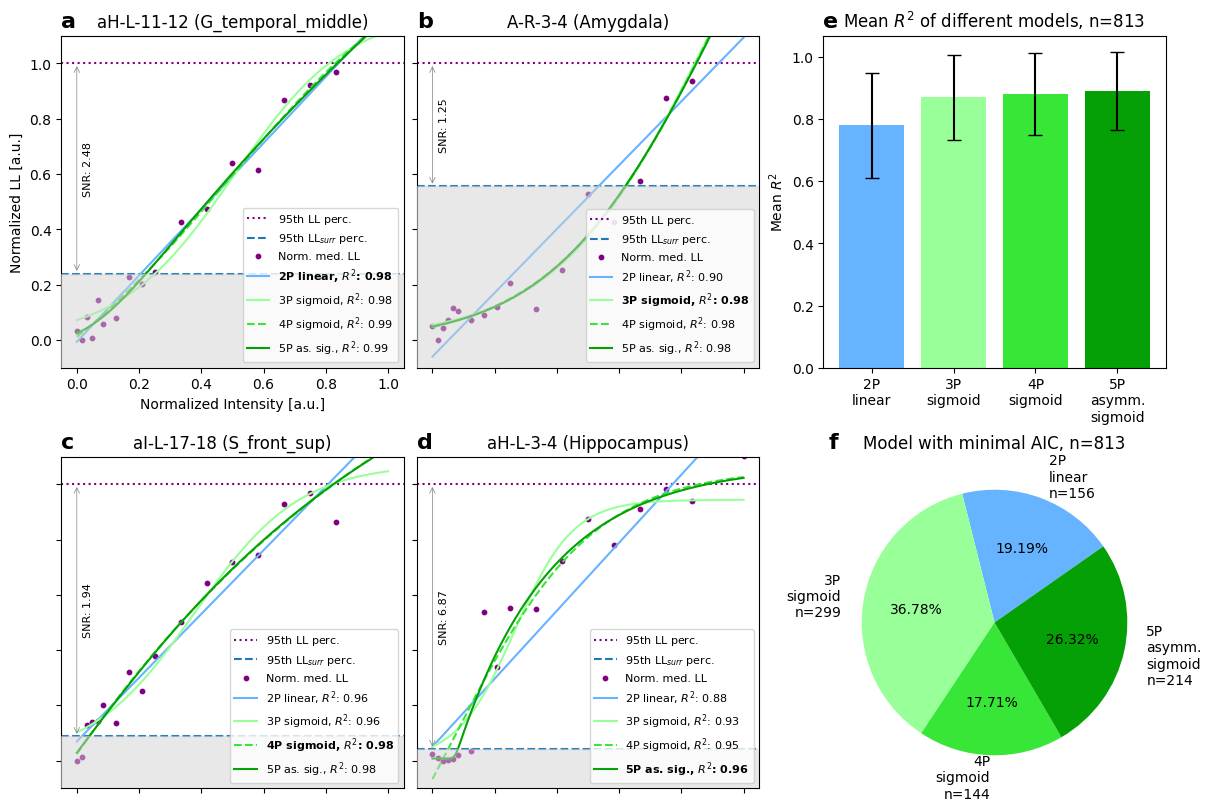

In [4]:


def plot_stimulation_response_curve(
    stim_channel_name_pos,
    stim_channel_name_neg,
    response_channel_pair,
    ax
):
    response_channel_name_pos = response_channel_pair[0]
    response_channel_name_neg = response_channel_pair[1]
    response_channel_name = response_channel_name_pos + "-" + response_channel_name_neg
    
    stim_channel_name = stim_channel_name_pos + "-" + stim_channel_name_neg

    result_dict = df_significant[
        (df_significant["patient_id"] == patient_id) &
        (df_significant["stim_channel_name"] == stim_channel_name) &
        (df_significant["response_channel_name"] == response_channel_name)
    ].squeeze()

    io_intensities = (
        logs[logs["type"] == "CR_IO"]["Int_prob"].drop_duplicates().tolist()
    )
    io_intensities.sort()
    io_intensities.insert(0, 0)

     # SNR

    norm_intensities = np.array(io_intensities) / max(io_intensities)
    norm_med_lls = np.array(result_dict["norm_med_lls"])
    med_lls = np.array(result_dict["med_lls"])

    surr_percentile = result_dict["surrogates_percentiles_med"]["95"]
    norm_surr_percentile = (surr_percentile - np.min(med_lls)) / (np.percentile(med_lls, q=95) - np.min(med_lls))

    # double arrow
    percentile_95 = np.nanpercentile(norm_med_lls, q=95)
    ax.axhline(percentile_95, linestyle=":", color="purple", label="95th $\\mathrm{LL}$ perc.")
    ax.axhline(norm_surr_percentile, linestyle="dashed", label="95th $\\mathrm{LL}_{surr}$ perc.")
    if np.abs(percentile_95 - norm_surr_percentile) > 0.2 and percentile_95 < 1.1 and norm_surr_percentile < 1.1: # only display double array if there is some space to do so
        arrow_pos = 0 # x position where the arrow will be drawn
        ax.annotate(
            '', 
            xy=(arrow_pos, percentile_95), 
            xytext=(arrow_pos, norm_surr_percentile),
            arrowprops=dict(arrowstyle='<->', color='gray', lw=0.5),
        )
        label_y = (percentile_95 + norm_surr_percentile) / 2
        ax.text(arrow_pos + 0.02, label_y, f"SNR: {result_dict["snr"]:.2f}", va='center', ha='left', color='black', fontsize=8, rotation=90, zorder=10)

    ax.set_ylim([-0.1, 1.1])

    # Fill below the line
    ax.axhspan(ax.get_ylim()[0], norm_surr_percentile, color='lightgray', alpha=0.5, zorder=3)

    # STIMULATION RESPONSE CURVE
    ax.scatter(
        norm_intensities, norm_med_lls, color="purple", s=10, label="Norm. med. LL"
    )
    # CURVE FITTING

    
    col_names = ["2P_d_aic", "3P_d_aic",  "4P_d_aic", "5P_d_aic"]
    min_aic_index = col_names.index(result_dict["d_aic_argmin"])
    friendly_curve_names = {f"2P": "2P linear", f"3P": "3P sigmoid", f"4P": "4P sigmoid", f"5P": "5P as. sig."}
    colors=[ "#66B3FF", "#99FF99", "#37E637", "#05A005"]
    linestyles=['solid', 'solid', 'dashed', 'solid']
    for k, curve in enumerate(curves):
        x_fit = np.linspace(0, 1, 1000)
        params = result_dict[curve["name"] + "_params"]
        
        y_fit = curve["function"](x_fit, *result_dict[curve["name"] + "_params"])
        ax.plot(
            x_fit,
            y_fit,
            label=f"{friendly_curve_names[curve['name']]}, $R^2$: {result_dict[curve["name"] + "_r_squared"]:.2f}",
            color=colors[k],
            linestyle=linestyles[k]
        )
    leg = ax.legend(loc="lower right", fontsize=8)
    leg.get_texts()[min_aic_index+3].set_fontweight("bold")

    



def plot_panel_e(ax_l, ax_r):
    names = [f"2P\nlinear", f"3P\nsigmoid", f"4P\nsigmoid", f"5P\nasymm.\nsigmoid"]
    colors=[ "#66B3FF", "#99FF99", "#37E637", "#05A005"]
    mean_r_squared = []
    std_r_squared = []
    for curve in curves:
        c_avg = np.nanmean(df_significant[curve["name"] + "_r_squared"])
        c_std = np.nanstd(df_significant[curve["name"] + "_r_squared"])
        mean_r_squared.append(c_avg)
        std_r_squared.append(c_std)
        print(f"{curve['name']}: {c_avg:.2f}$\\pm${c_std:.2f}")


    ax_l.bar(
        names, mean_r_squared, yerr=std_r_squared, color=colors, capsize=5
    )
    ax_l.set_ylabel("Mean $R^2$")
    ax_l.set_title(f"Mean $R^2$ of different models, n={len(df_significant)}")
   
    len_min_2P = len(df_significant[df_significant["d_aic_argmin"] == "2P_d_aic"])
    len_min_3P = len(df_significant[df_significant["d_aic_argmin"] == "3P_d_aic"])
    len_min_4P = len(df_significant[df_significant["d_aic_argmin"] == "4P_d_aic"])
    len_min_5P = len(df_significant[df_significant["d_aic_argmin"] == "5P_d_aic"])

    values = [
            len_min_2P,
            len_min_3P,
            len_min_4P,
            len_min_5P,
        ]
    ax_r.pie(
        values,
        labels=[f"{n}\nn={values[i_n]}" for i_n, n in enumerate(names)],
        colors=colors,
        autopct="%1.2f%%",
        startangle=35,
        labeldistance=1.17,     # push labels further out (default=1.1)
        #pctdistance=0.85,       # adjust percentage text distance
    )
    ax_r.set_title(f"Model with minimal AIC, n={len(df_significant)}")


fig = plt.figure(figsize=(12, 8), constrained_layout=True)
gs = GridSpec(
    2, 3, figure=fig, height_ratios=[1,1]
)

grid_rows = [0, 0, 1, 1]
grid_cols = [0, 1, 0, 1]
names = ["a", "b", "c", "d"]


first_ax = None
for j, name in enumerate(names):
    ax = fig.add_subplot(gs[grid_rows[j], grid_cols[j]], sharex=first_ax, sharey=first_ax)
    ax.set_title(name, loc='left', fontsize=16, fontweight='bold')
    resp_channel_name = "-".join(response_channel_pairs[j])
    destr_label = mrl.get_destrieux_labels_from_names(channel_names=[resp_channel_name], short_form=True)[0]
    ax.set_title(f"{friendly_response_channel_names[j]} ({destr_label})")

    plot_stimulation_response_curve(
        stim_channel_name_pos=stim_channel_name_pos,
        stim_channel_name_neg=stim_channel_name_neg,
        response_channel_pair=response_channel_pairs[j],
        ax=ax
    )
    if j == 0:
        ax.set_ylabel("Normalized LL [a.u.]")
        ax.set_xlabel("Normalized Intensity [a.u.]")
        first_ax = ax
    else:
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)

ax_el = fig.add_subplot(gs[0, 2])
ax_el.set_title("e", loc='left', fontsize=16, fontweight='bold')
ax_er = fig.add_subplot(gs[1, 2])
ax_er.set_title("f", loc='left', fontsize=16, fontweight='bold')


plot_panel_e(ax_l=ax_el, ax_r=ax_er)

plt.savefig("../output/figures/figure2.pdf", bbox_inches='tight', dpi=300)
plt.savefig("../output/figures/figure2.svg", bbox_inches='tight', dpi=300)
plt.show()